In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats as st
from scipy.stats import spearmanr
from scipy.stats.stats import pearsonr
from numpy import sqrt

import warnings
warnings.filterwarnings('ignore')

import random

## Доверительные интервалы

Построим диаграмму зависимости количества проданной пиццы от дня недели. Выведем дни недели, в которые продано **больше** и  **меньше** всего пиццы.

In [ ]:
pizza_df = pd.read_csv('../datasets/pizza.csv', sep=';')
pizza_df[['order_date', 'order_time', 'lead_time']] = pizza_df[['order_date', 'order_time', 'lead_time']].apply(pd.to_datetime)
pizza_df['weekday'] = pizza_df['order_date'].dt.day_name()
pizza_sale = pizza_df['weekday'].value_counts().reset_index()
pizza_sale

,weekday,count
0,Thursday,857
1,Friday,818
2,Saturday,706
3,Tuesday,702
4,Wednesday,655
5,Monday,634
6,Sunday,628


In [ ]:
print(f'Больше всего пиццы({pizza_sale.iloc[:, 1][0]} шт) было продано on {pizza_sale.iloc[:, 0][0]}')
print(f'Меньше всего пиццы({pizza_sale.iloc[:, 1][6]} шт) было продано on {pizza_sale.iloc[:, 0][6]}')


Больше всего пиццы(857 шт) было продано on Thursday
Меньше всего пиццы(628 шт) было продано on Sunday


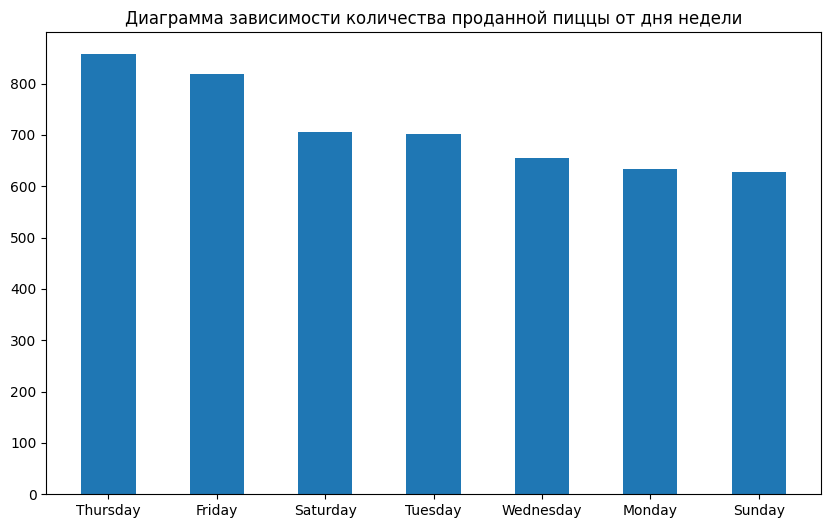

In [ ]:
fig = plt.figure(figsize=(10, 6))
plt.bar(pizza_sale['weekday'], pizza_sale['count'], width=0.5)
plt.title('Диаграмма зависимости количества проданной пиццы от дня недели')
plt.show()

Посчитаем время приготовления каждой пиццы(в секундах) по всем заказам. 
Найдем mean, median, max и min время приготовления пиццы.

In [ ]:
pizza_df['cook_time'] = (pizza_df['lead_time'] - pizza_df['order_time']).dt.seconds
pizza_min = pizza_df['cook_time'].min().round()
pizza_max = pizza_df['cook_time'].max().round()
pizza_median = pizza_df['cook_time'].median().round()
pizza_mean = pizza_df['cook_time'].mean().round()

print(f'Среднее значение = {pizza_mean} \n'
      f'Медианное значение = {pizza_median} \n'
      f'Максимальное значение = {pizza_max} \n'
      f'Минимальное значение = {pizza_min}')

Среднее значение = 1007.0 
Медианное значение = 1006.0 
Максимальное значение = 1609 
Минимальное значение = 444


95% ДИ для среднего времени приготовления пиццы выглядит следующим образом:

In [ ]:
data = pizza_df['cook_time']
conf_int = st.norm.interval(confidence=0.95, loc=np.mean(data), scale=np.std(data, ddof=1)/np.sqrt(len(data)))

print([conf_int[0].round(), conf_int[1].round()])

[1002.0, 1012.0]


In [ ]:
#найдем все пиццы, количество которых больше 100
pizza_names = pizza_df['pizza_name'].value_counts().reset_index()
pizza_names = pizza_names[pizza_names['count'] > 100]

#сократим датафрейм с пиццами из вышевычисленного списка
pizzas = pizza_df[pizza_df.pizza_name.isin(pizza_names.pizza_name)]

In [ ]:
'''Найдем пиццы с самой большой верхней границей ДИ и с самым широким ДИ.'''

pizza_max = ''
max_interval = 0
max_diff = 0
pizza_diff = ''

for pizza in pizza_names.pizza_name:
    pizza_cook_time = pizzas[pizzas.pizza_name == pizza]
    pizza_interval = st.norm.interval(confidence=0.95, loc=np.mean(pizza_cook_time.cook_time), scale=st.sem(pizza_cook_time.cook_time))
    if pizza_interval[1] > max_interval:
        max_interval = pizza_interval[1]
        pizza_max = pizza
    if pizza_interval[1] - pizza_interval[0] > max_diff:
        max_diff = pizza_interval[1] - pizza_interval[0]
        pizza_diff = pizza

print(f'Самая высокая верхняя граница ДИ({max_interval}) у пиццы {pizza_max}\n'
      f'Самый широкий ДИ({max_diff}) у пиццы {pizza_diff}')


Самая высокая верхняя граница доверительного интервала: 1068.4259922985843
Пицца: The Italian Vegetables Pizza


# AB тестирование

В качестве нулевой гипотезы (H0) выбрано суждение о том, что старый баннер лучше нового. В качестве альтернативной гипотезы (H1) выбрано суждение о том, что новый баннер лучше старого.
Построим 95% ДИ для доли каждого из баннеров и узнаем пересекаются ли эти интервалы.

In [ ]:
click_df = pd.read_csv('../datasets/click.csv')
click_df.head()

,banner_a,banner_b
0,0,0
1,1,1
2,0,0
3,0,0
4,0,0


In [ ]:
from statsmodels.stats.proportion import proportion_confint

interval_h0 = proportion_confint(click_df.banner_a.sum(), len(click_df.banner_a), alpha=0.05, method='normal')

interval_h1 = proportion_confint(click_df.banner_b.sum(), len(click_df.banner_b), alpha=0.05, method='normal')


print(f'Интервал для баннера А = {interval_h0}')
print(f'Интервал для баннера В = {interval_h1}')

if interval_h1[0] > interval_h0[1] or interval_h0[0] > interval_h1[1]:
    print('Интервалы не пересекаются')
else:
    print('Интервалы пересекаются')

Интервал для баннера А = (0.02530064022092865, 0.04869935977907135)
Интервал для баннера В = (0.03911451622486782, 0.06688548377513218)
Интервалы пересекаются


Для более детальной оценки построим 95% ДИ для разности двух долей.

In [ ]:
p_a = click_df.banner_a.sum()/len(click_df.banner_a)
p_b = click_df.banner_b.sum()/len(click_df.banner_b)
z = st.norm.ppf(1-0.05/2)
left_int = p_a - p_b - z * (p_a * (1 - p_a) / len(click_df.banner_a) + p_b * (1 - p_b) / len(click_df.banner_b)) ** 0.5
right_int = p_a - p_b + z * (p_a * (1 - p_a) / len(click_df.banner_a) + p_b * (1 - p_b) / len(click_df.banner_b)) ** 0.5

print(f'95% ДИ для разности двух долей: [{left_int.round(5)}, {right_int.round(5)}]')

95% доверительный интервал для разности двух долей: [-0.03416, 0.00216]


Проведем АБ-тест

In [ ]:
def z_stat(sample1, sample2):
    n_a = len(sample1)
    n_b = len(sample2)

    p_a = float(sum(sample1)) / n_a
    p_b = float(sum(sample2)) / n_b 
    P = float(p_a * n_a + p_b * n_b) / (n_a + n_b)
  
    return (p_a - p_b) / np.sqrt(P * (1 - P) * (1. / n_a + 1. / n_b))

In [ ]:
z_value = z_stat(click_df.banner_a, click_df.banner_b)
p_value = st.norm.sf(abs(z_value))

alpha = 0.05
if p_value > alpha:
    print(f'Нулевая гипотеза H0: старый баннер А лучше нового В \n'
          f'Z-value, полученное в результате проверки гипотезы, равно {z_value} \n'
          f'p_value, связанное с найденной оценкой z_value, равно {p_value} \n'
          f'Мы не можем отвергнуть нулевую гипотезу, значит старый баннер А лучше нового баннера В')
else:
    print(f'Нулевая гипотеза H0: старый баннер А лучше нового В \n'
          f'Z-value, полученное в результате проверки гипотезы, равно {z_value} \n'
          f'p_value, связанное с найденной оценкой z_value, равно {p_value} \n'
          f'Мы отвергаем нулевую гипотезу, а значит новый баннер В лучше старого А')




Нулевая гипотеза H0: старый баннер А лучше нового В 
Z-value, полученное в результате проверки гипотезы, равно -1.7258261378415294 
p_value, связанное с найденной оценкой z_value, равно 0.042189348005533284 
Мы отвергаем нулевую гипотезу, а значит новый баннер В лучше старого А


## Корреляции

Сгенерируем выборки и посчитаем корреляции Пирсона и Спирмена для выборок `(x; y1)`, `(x; y2)`, `(x; y3)`. Объясним полученные результаты.

In [ ]:
x = np.linspace(-10,10,100)
y1 = x ** 2
y2 = -x **2
y3 = np.log(x ** 2 + 1)

In [ ]:
y = [y1, y2, y3]

pearson = [pearsonr(x, y_n) for y_n in y]
spearman = [spearmanr(x, y_n) for y_n in y]

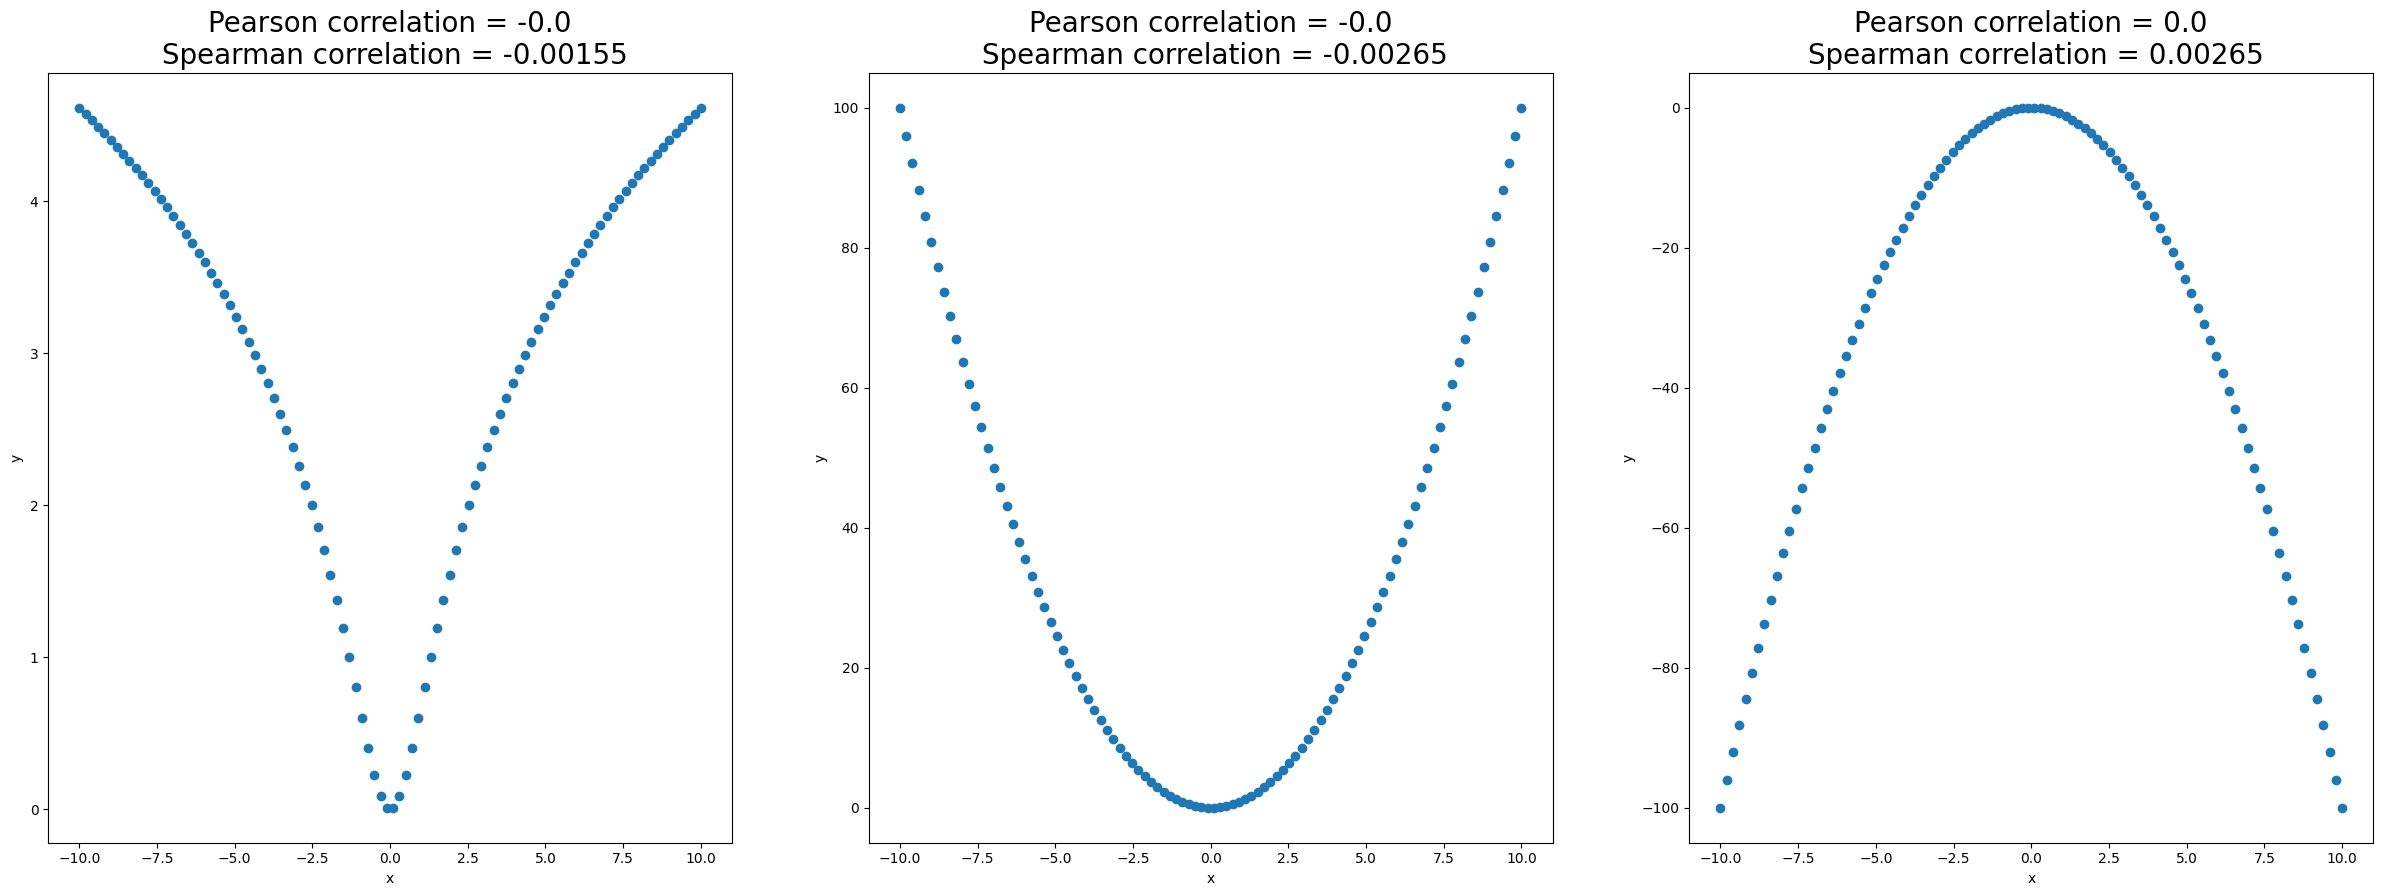

In [ ]:
fig, ax = plt.subplots(1, 3, figsize=(30, 10))

for i in range(3):
    ax[i].scatter(x, y[i-1])
    ax[i].set_title(f'Pearson correlation = {pearson[i-1].statistic.round(5)}\n Spearman correlation = {spearman[i-1].statistic.round(5)}', fontsize=20)
    ax[i].set(xlabel='x', ylabel='y')


plt.show()

#### Вывод
Корреляции Пирсона и Спирмана имеют околонулевое значение, что означает, что между переменными нет линейной зависимости.
Однако это изначально видно по представленным нелинейным графикам.

### Проверим устойчивы ли коэффициенты корреляции к выбросам

Построим облако из точек.
Выведем значения коэффициентов корреляции.
Случайным образом создадим выбросы. 
Для каждого расстояния рассчитаем коэффициент корреляции Пирсона и Спирмана.
Сделаем вывод о том, какая корреляция больше устойчива к выбросам.

In [ ]:
step = np.linspace(-10, 0, 1000)
x = -step + np.random.randn(1000) * 0.2
y = step + np.random.randn(1000)* 0.2

#зададим смещение
move_x = [25, 50, 150, 650]
move_y = [20, 40, 60, 80]

#рассчитаем корреляции
print(f'До:\n'
      f'Корреляция Пирсона = {pearsonr(x, y).statistic}\n'
      f'Корреляция Спирмана = {spearmanr(x, y).statistic}')

#выберем индексы случайных точек
random_indexes =  random.sample(range(len(x)), 4)

#изменим координаты случайных точек
for i in range(4):
    x[random_indexes[i]] += move_x[i]
    y[random_indexes[i]] += move_y[i]

#рассчитаем новые корреляции
print(f'После:\n'
      f'Корреляция Пирсона = {pearsonr(x, y).statistic}\n'
      f'Корреляция Спирмана = {spearmanr(x, y).statistic}')

До:
Корреляция Пирсона = -0.9954889410673162
Корреляция Спирмана = -0.9956186276186276
После:
Корреляция Пирсона = 0.5854195888769208
Корреляция Спирмана = -0.9717681957681958


#### Вывод

Как можно увидеть корреляция Спирмана более устойчива к выбросам, чем корреляция Пирсона

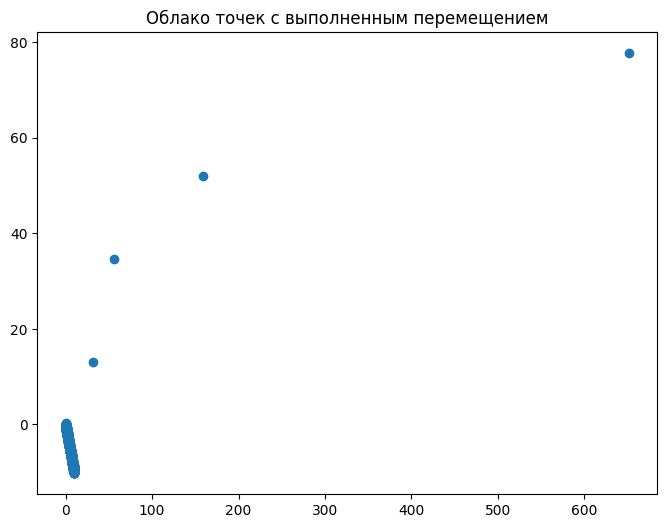

In [ ]:
fig2 = plt.figure(figsize=(8, 6))
plt.scatter(x, y)
plt.title('Облако точек с выполненным перемещением')
plt.show()